# Exploring data from the 2017 Boston Marathon


We are going to make use of the data from the finishers of the 2017 Boston Marathon extracted from the zipped folder at the start of the course.   
This data is already provided to you here for download. Alternatively, you can access the data through Kaggle.

### Questions you need to answer

Throughout the exploration process, there are a few questions you might be able to answer from this data:

1. Are men faster than women?
2. Are younger people faster than older?
3. Which country is the fastest?
3. How many people have ‘negative splits’ (they ran the second half of the race faster than the first?


# 0 - setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import pandas as pd
import duckdb
from plotnine import *

# define a sqldf function that uses duckdb to execute sql select queries
sqldf = lambda q: duckdb.query(q).to_df()

# 1 - get the data, and have quick look

In [2]:
dat = pd.read_csv('./dat/marathon_results_2017.csv',index_col=False)
print(dat.shape)
dat.head(3)

(26410, 25)


,Unnamed: 0,Bib,Name,Age,M/F,City,State,Country,Citizen,Unnamed: 9,...,25K,30K,35K,40K,Pace,Proj Time,Official Time,Overall,Gender,Division
0,0,11,"Kirui, Geoffrey",24,M,Keringet,NaN,KEN,NaN,NaN,...,1:16:59,1:33:01,1:48:19,2:02:53,0:04:57,-,2:09:37,1,1,1
1,1,17,"Rupp, Galen",30,M,Portland,OR,USA,NaN,NaN,...,1:16:59,1:33:01,1:48:19,2:03:14,0:04:58,-,2:09:58,2,2,2
2,2,23,"Osako, Suguru",25,M,Machida-City,NaN,JPN,NaN,NaN,...,1:17:00,1:33:01,1:48:31,2:03:38,0:04:59,-,2:10:28,3,3,3


In [3]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26410 entries, 0 to 26409
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     26410 non-null  int64 
 1   Bib            26410 non-null  object
 2   Name           26410 non-null  object
 3   Age            26410 non-null  int64 
 4   M/F            26410 non-null  object
 5   City           26410 non-null  object
 6   State          22815 non-null  object
 7   Country        26410 non-null  object
 8   Citizen        1254 non-null   object
 9   Unnamed: 9     91 non-null     object
 10  5K             26410 non-null  object
 11  10K            26410 non-null  object
 12  15K            26410 non-null  object
 13  20K            26410 non-null  object
 14  Half           26410 non-null  object
 15  25K            26410 non-null  object
 16  30K            26410 non-null  object
 17  35K            26410 non-null  object
 18  40K            26410 non-n

## Data selection and preparation 

The questions were:

1. Are men faster than women?
2. Are younger people faster than older?
3. Which country is the fastest?
3. How many people have ‘negative splits’ (they ran the second half of the race faster than the first?

So for each case we need the columns
- Unnamed first column (i.e the row number, this is effectively the ID of the runner - i.e an runID -).  Bib probably is the shirtnumber that in pinned to shirt of the runners, if so, we could use bib as an identifier for runner. (Males and females have their own numbering?)
- M/F (sex would be a better name)
- Age
- Country (maybe relevant to determine nationality of the runner)
- Citizen (maybe relevant to determine nationality of the runner)
- Half (time clocked at the half of the marathon)
- Official time (time clocked at the end of the marathon)

Lets select the columns really needed

In [4]:
dat_tot = dat.copy() # keep a copy of the original data for save keeping

Lets have a look at the column names and rename those who are badly named.

In [5]:
# show current col names
dat_tot.columns

Index(['Unnamed: 0', 'Bib', 'Name', 'Age', 'M/F', 'City', 'State', 'Country',
       'Citizen', 'Unnamed: 9', '5K', '10K', '15K', '20K', 'Half', '25K',
       '30K', '35K', '40K', 'Pace', 'Proj Time', 'Official Time', 'Overall',
       'Gender', 'Division'],
      dtype='object')

In [6]:
# Rename needed col names to something palatable 
betterColNames = ['runID', 'Bib', 'Name', 'age', 'sex', 'City', 'State', 'country',
       'citizen', 'Unnamed: 9', '5K', '10K', '15K', '20K', 'halfTime', '25K',
       '30K', '35K', '40K', 'Pace', 'Proj Time', 'endTime', 'Overall',
       'Gender', 'Division']
dat_tot.columns = betterColNames
dat_tot.head(1)

,runID,Bib,Name,age,sex,City,State,country,citizen,Unnamed: 9,...,25K,30K,35K,40K,Pace,Proj Time,endTime,Overall,Gender,Division
0,0,11,"Kirui, Geoffrey",24,M,Keringet,NaN,KEN,NaN,NaN,...,1:16:59,1:33:01,1:48:19,2:02:53,0:04:57,-,2:09:37,1,1,1


In [7]:
# get the needed columns
dat = sqldf("""
SELECT runID, sex, age, country, citizen, halfTime, endTime
FROM dat_tot
ORDER BY 1
""")
print(dat.shape)
dat.head()

(26410, 7)


,runID,sex,age,country,citizen,halfTime,endTime
0,0,M,24,KEN,NaN,1:04:35,2:09:37
1,1,M,30,USA,NaN,1:04:35,2:09:58
2,2,M,25,JPN,NaN,1:04:36,2:10:28
3,3,M,32,USA,NaN,1:04:45,2:12:08
4,4,M,31,KEN,NaN,1:04:35,2:12:35


In [8]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26410 entries, 0 to 26409
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   runID     26410 non-null  int64 
 1   sex       26410 non-null  object
 2   age       26410 non-null  int64 
 3   country   26410 non-null  object
 4   citizen   1254 non-null   object
 5   halfTime  26410 non-null  object
 6   endTime   26410 non-null  object
dtypes: int64(2), object(5)
memory usage: 1.4+ MB


Only citizen has missing values (a lot of them).  
PS halfTime has sometimes a '-' that effectively is a missing value.

Note that halfTime and endTime have the Dtype object (i.e. strings).  
Common sense teaches that these are times of the format h:mm:ss  (h=hour as digit, m=minute as digit and s seconds as digit)

To answer the questions it would be best if we had these times in seconds.

in the standard Python module datetime there are functions to get the time in seconds.   
Here we will create our own function to translate the 'h:mm:ss' string into seconds  
(where seconds = 3600xh + 60xmm + ss)

In [9]:
def get_seconds(hmmss):
# assumption: hmmss is either a string formatted as '9:99:99' or a string less than 7 characters long
# this assumption holds for our data, but may not relied upon in general
# note: 0 is effectively a missing value
    if len(hmmss) == 7:
        [hh,mm,ss] = hmmss.split(':')
        return int(hh)*3600 + int(mm)*60 + int(ss)
    else:
        return 0
    
dat['halfSec'] = dat['halfTime'].apply(get_seconds)
dat['endSec']  = dat['endTime' ].apply(get_seconds)

dat.head()

,runID,sex,age,country,citizen,halfTime,endTime,halfSec,endSec
0,0,M,24,KEN,NaN,1:04:35,2:09:37,3875,7777
1,1,M,30,USA,NaN,1:04:35,2:09:58,3875,7798
2,2,M,25,JPN,NaN,1:04:36,2:10:28,3876,7828
3,3,M,32,USA,NaN,1:04:45,2:12:08,3885,7928
4,4,M,31,KEN,NaN,1:04:35,2:12:35,3875,7955


Note - there are 17 cases that have halfTme == 0 (i.e halfTime is missing), all cases have an endTime.

In [10]:
sqldf('select count(*) from dat where halfSec == 0')

,count_star()
0,17


In [11]:
sqldf('select count(*) from dat where endSec == 0')

,count_star()
0,0


# Q1 - are men faster than woman

In [12]:
# compare the average time for different sexes
sqldf("""
SELECT sex, ROUND(AVG(endSec)) AS average_time
FROM dat
GROUP BY sex
""")

,sex,average_time
0,M,13735.0
1,F,14945.0


In [13]:
14945 - 13734

1211

So men are on average 1211 seconds faster than women.   

Lets compare the mens and females endTime distributions

<AxesSubplot:xlabel='endSec', ylabel='Count'>

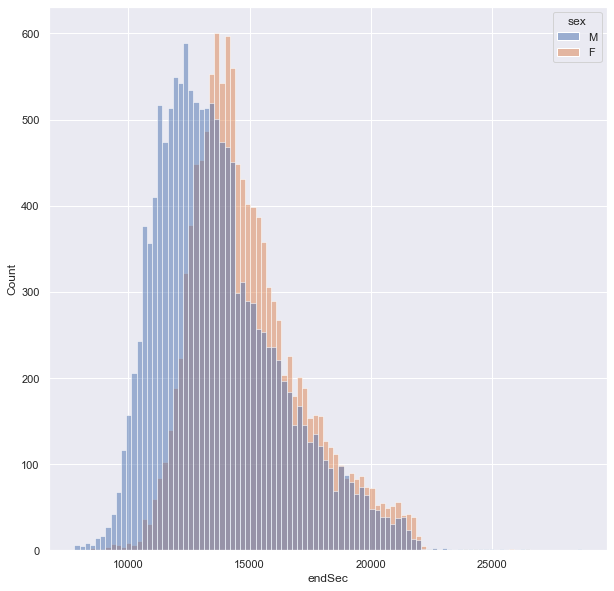

In [14]:
sns.set(rc={'figure.figsize':(10,10)}) 

sns.histplot(data=dat, x="endSec", hue="sex")

So the fastest runners are almost all men.  
Among the slowest runners there is little difference between men and women.

<AxesSubplot:xlabel='endSec', ylabel='sex'>

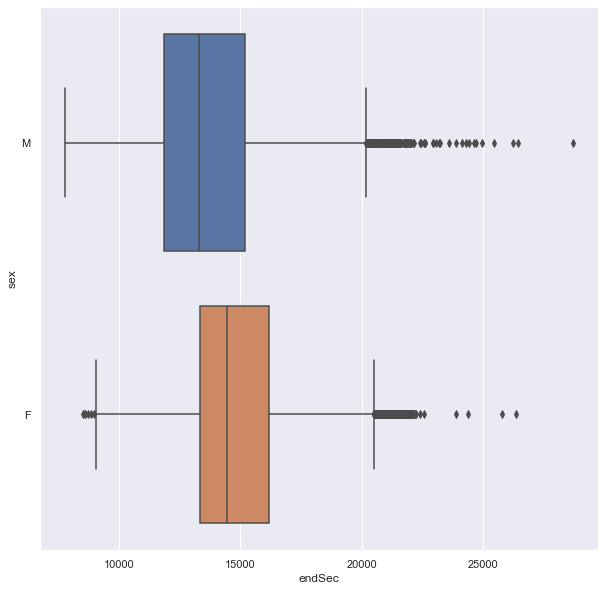

In [15]:
# show distribution using boxplots
sns.boxplot( data=dat, x="endSec", y="sex")

<AxesSubplot:xlabel='endSec', ylabel='sex'>

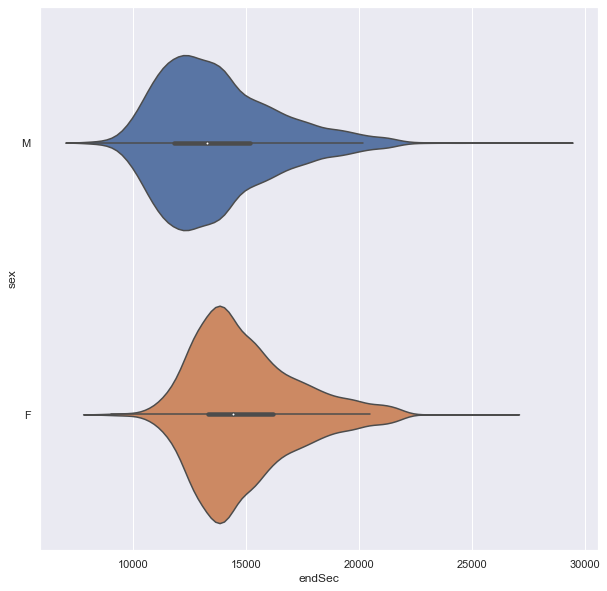

In [16]:
# show distribution using violinplots
sns.violinplot(data=dat, x="endSec", y="sex")

# Q2 - Are younger people faster than older?

In [17]:
# create a dataframe ageDif that has for every age the average endSec
ageDif = sqldf("""
SELECT age, COUNT(*) AS cnt, ROUND(AVG(endSec)) AS ageAvgTime
FROM dat
GROUP BY age
ORDER BY age
""")
print(ageDif.shape)
ageDif.head(10)

(66, 3)


,age,cnt,ageAvgTime
0,18,20,15486.0
1,19,43,15231.0
2,20,83,14254.0
3,21,147,13784.0
4,22,210,14197.0
5,23,307,14023.0
6,24,450,14267.0
7,25,498,14011.0
8,26,557,13714.0
9,27,571,14066.0


<AxesSubplot:xlabel='age', ylabel='ageAvgTime'>

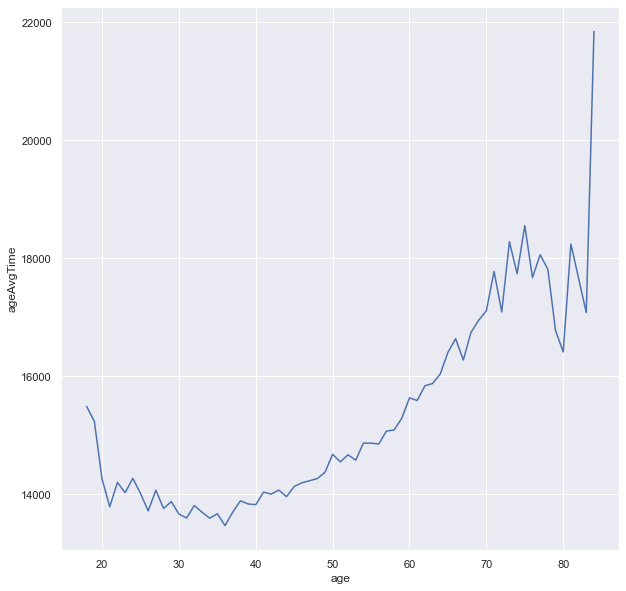

In [18]:
sns.lineplot(data=ageDif, x="age", y="ageAvgTime")

The very young are not yet in the strength of there lives.  
But for others the 20 to 40 years old are the fastest (Not much difference among them).  
40+ people get progressively slower.

Lets filter out the ages that have less than 11 cases


In [19]:
ageDif2 = sqldf("SELECT * FROM ageDif WHERE cnt > 10")

<AxesSubplot:xlabel='age', ylabel='ageAvgTime'>

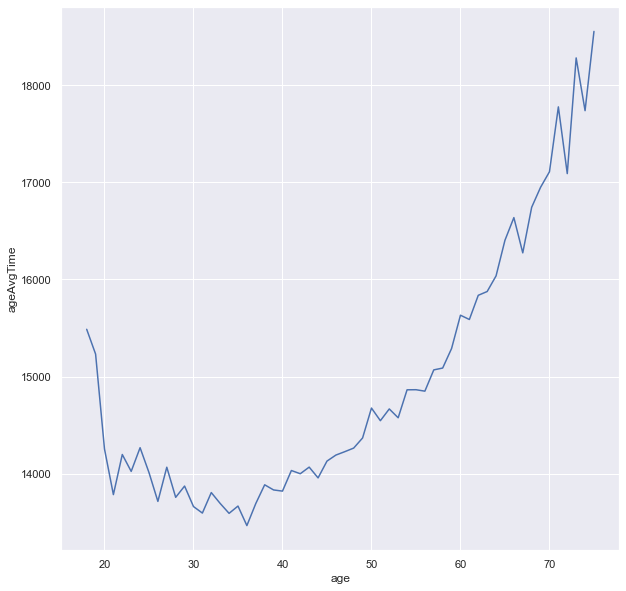

In [20]:
sns.lineplot(data=ageDif2, x="age", y="ageAvgTime")

The over 75 cases get eliminated (a few very unusual individuals that convolute the general trend)

Lets see if there is a difference between men and woman

In [21]:
ageDif2 = sqldf("""
SELECT sex, age, COUNT(*) AS cnt, ROUND(AVG(endSec)) AS ageAvgTime
FROM dat
GROUP BY sex, age
HAVING COUNT(*) > 10
ORDER BY age, sex
""")
print(ageDif2.shape)
ageDif2.head()

(108, 4)


,sex,age,cnt,ageAvgTime
0,F,18,11,17288.0
1,F,19,20,15924.0
2,M,19,23,14628.0
3,F,20,40,15859.0
4,M,20,43,12761.0


<AxesSubplot:xlabel='age', ylabel='ageAvgTime'>

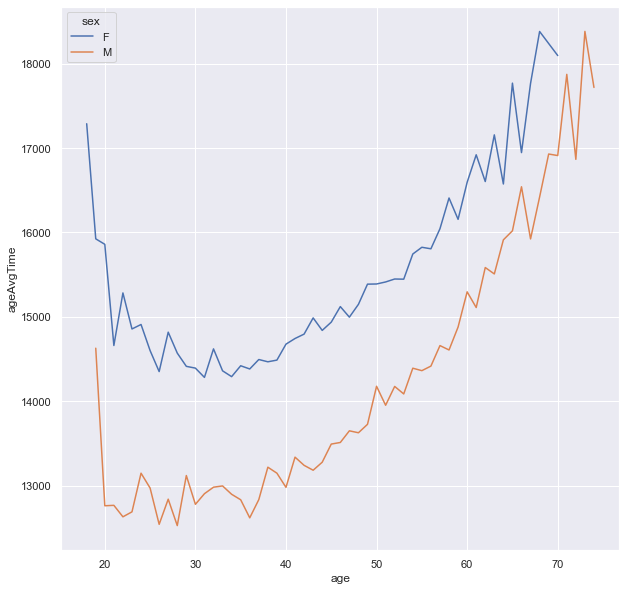

In [22]:
# view the sexist and ageist distribution
sns.lineplot(data=ageDif2, x="age", y="ageAvgTime", hue='sex')

### seaborn challenge

Can anyone reproduce the ggplot figures below, using seaborn only.   

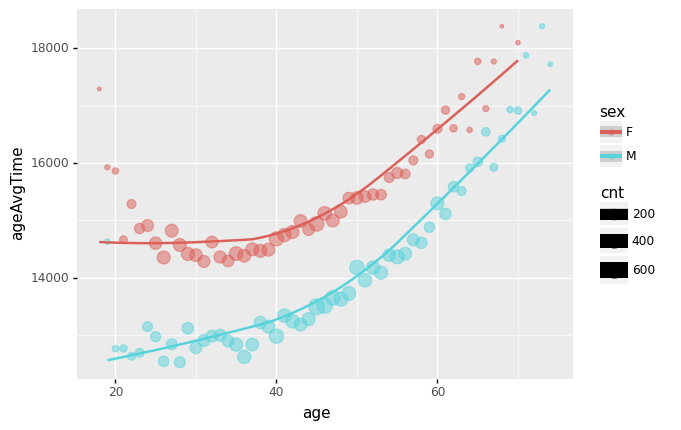

<ggplot: (-9223371877963220056)>

In [58]:
ggplot(data=ageDif2, mapping=aes(x='age',y='ageAvgTime', color='sex', size='cnt')) + \
    geom_point(alpha=0.5) + \
    geom_smooth()

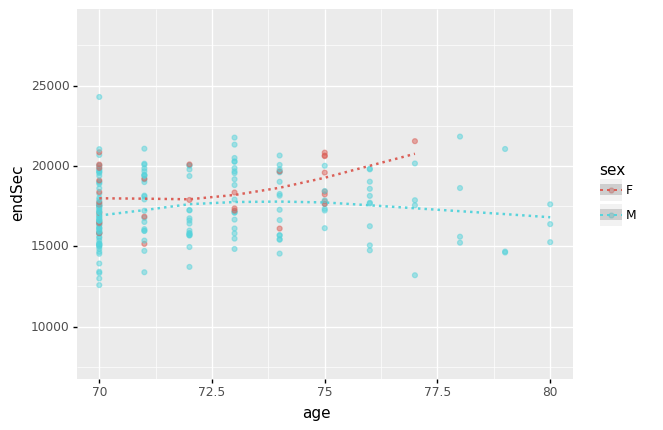

<ggplot: (-9223371878011897448)>

In [24]:
ggplot(data=dat,mapping=aes(x='age',y='endSec', color='sex')) + \
    geom_point(alpha=0.5) + \
    geom_smooth(method='lowess', linetype='dotted') + \
    xlim([70,80]) 

# Q3 - Which country is the fastest?

Note that there are cases where country (country of residence) is not the same as the country where the runner is a citizen of.

In [25]:
sqldf("SELECT runID, country, citizen FROM dat WHERE citizen IS NOT NULL LIMIT 10")

,runID,country,citizen
0,16,USA,MAR
1,18,USA,ZIM
2,21,MEX,KEN
3,49,USA,CRC
4,60,USA,IRL
5,66,USA,CRC
6,73,CAN,FRA
7,177,SUI,AUS
8,182,USA,TRI
9,206,USA,IRL


Countries are identified by a 3 letter code [see wikipedia](https://en.wikipedia.org/wiki/ISO_3166-1)

Here we will assume that we have to compare the countries mentioned in the column country. 

In [26]:
sqldf("""
SELECT 
    country, 
    COUNT(*)           AS cnt, 
    MIN(endSec)        AS countryBest,
    ROUND(AVG(endSec)) AS countryAVG,
    MAX(endSec)        AS countryLast
FROM dat 
GROUP BY country 
ORDER BY 4 
LIMIT 10
""")

,country,cnt,countryBest,countryAVG,countryLast
0,ZIM,1,8260,8260.0,8260
1,KEN,8,7777,8479.0,9108
2,BRN,1,8571,8571.0,8571
3,ETH,5,8066,8829.0,9607
4,BDI,1,9144,9144.0,9144
5,PAN,4,9937,10982.0,11974
6,FLK,1,11424,11424.0,11424
7,JAM,1,11520,11520.0,11520
8,SRB,1,11601,11601.0,11601
9,MLT,1,11666,11666.0,11666


If we interpret the speed of a country as the average speed of the runners from that country then ZIM (Zimbabwe) is the best country followed by Kenya.

It appears that countries that are far away from Boston have the best average speeds.  
We may assume that only pro's take the trouble to travel to Boston from far away.   
The USA and CAN - both close to Boston - have many hobby runners, these hobbyist drag the average upwards.  
So we are comparing apples and oranges when we do it this way.

We might reinterpret the fastest country as, the country that has the fastest runner.  
Lets do that.

In [27]:
sqldf("""
SELECT 
    country, 
    COUNT(*)           AS cnt, 
    MIN(endSec)        AS countryBest,
    ROUND(AVG(endSec)) AS countryAVG,
    MAX(endSec)        AS countryLast
FROM dat 
GROUP BY country 
ORDER BY 3
LIMIT 10
""")

,country,cnt,countryBest,countryAVG,countryLast
0,KEN,8,7777,8479.0,9108
1,USA,20945,7798,14382.0,28694
2,JPN,170,7828,15017.0,23043
3,ETH,5,8066,8829.0,9607
4,ZIM,1,8260,8260.0,8260
5,MEX,285,8540,13536.0,20739
6,BRN,1,8571,8571.0,8571
7,BRA,205,8715,13425.0,20914
8,CAN,1870,8812,13775.0,24730
9,ITA,165,9011,14534.0,21576


Now KEN wins and the USA is second, ZIM drops to place five.

A third way to compare countries is to demand that there are at least 100 runners from that country, and assume that these big cohorts have comparable mixes of pro's and amateurs.

In [28]:
best = sqldf("""
SELECT 
    country, 
    COUNT(*)           AS cnt, 
    MIN(endSec)        AS countryBest,
    ROUND(AVG(endSec)) AS countryAVG,
    MAX(endSec)        AS countryLast
FROM dat 
GROUP BY country 
HAVING COUNT(*) > 99
ORDER BY 4
""")
best.head(30)

,country,cnt,countryBest,countryAVG,countryLast
0,BRA,205,8715,13425.0,20914
1,FRA,114,9705,13531.0,21236
2,MEX,285,8540,13536.0,20739
3,GBR,425,9225,13570.0,21718
4,AUS,191,9947,13758.0,21597
5,CAN,1870,8812,13775.0,24730
6,ESP,132,9524,14191.0,20297
7,USA,20945,7798,14382.0,28694
8,ITA,165,9011,14534.0,21576
9,GER,226,9358,14573.0,21326


In [59]:
indiv_from_best = sqldf("""
SELECT runID, country, sex, endSec
FROM dat
WHERE country IN (SELECT country FROM best)
ORDER BY 4
""")
print(indiv_from_best.shape)
indiv_from_best.head()

(24970, 4)


,runID,country,sex,endSec
0,1,USA,M,7798
1,2,JPN,M,7828
2,3,USA,M,7928
3,5,USA,M,7965
4,6,USA,M,7996


<AxesSubplot:xlabel='endSec', ylabel='country'>

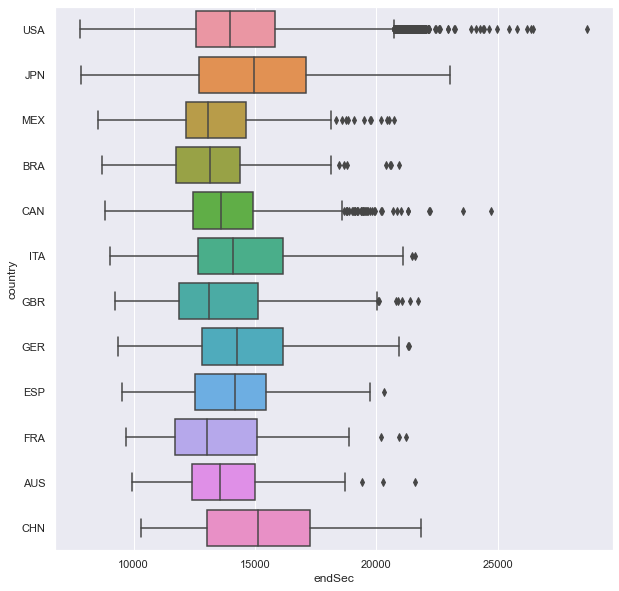

In [30]:
# show distribution of endSec per country using boxplots
sns.boxplot( data=indiv_from_best, x="endSec", y="country")

<AxesSubplot:xlabel='endSec', ylabel='country'>

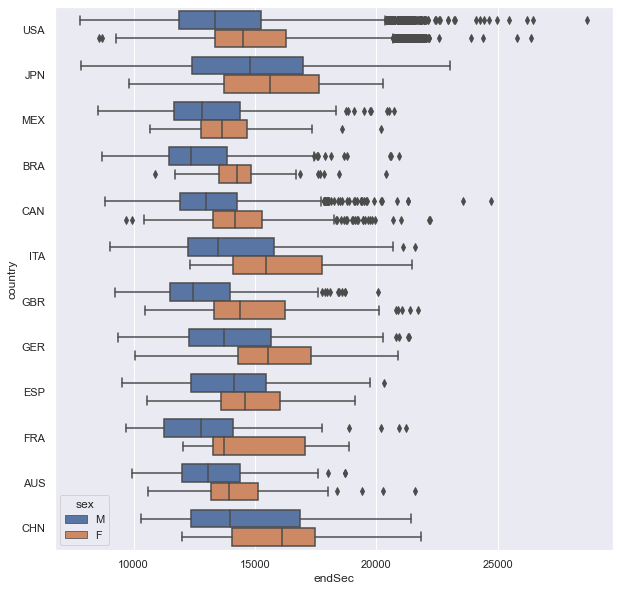

In [31]:
# show distribution of endSec per country using boxplots per sex
sns.boxplot( data=indiv_from_best, x="endSec", y="country", hue="sex")

# How many people have ‘negative splits’ 

Runners have a negative splits if they ran the second half of the race faster than the first.

Note that there were 17 cases where halfTime = 0 (i.e. halftimes are missing).  
We will remove these cases from out data

In [33]:
print(dat.shape)
dat2 = sqldf("SELECT * FROM dat WHERE halfSec <> 0")
print(dat2.shape)

(26410, 9)
(26393, 9)


In [34]:
dat3 = sqldf("""
SELECT
    runID, sex, age, country, citizen, halfTime, endTime, halfSec, 
    endSec - halfSec AS secondHalfSec,
    endSec,
    CASE
        WHEN (endSec - halfSec) < halfSec THEN 'yes' 
        ELSE 'no' 
    END AS split
FROM dat2    
""")
print(dat3.shape)
dat3.head()

(26393, 11)


,runID,sex,age,country,citizen,halfTime,endTime,halfSec,secondHalfSec,endSec,split
0,0,M,24,KEN,NaN,1:04:35,2:09:37,3875,3902,7777,no
1,1,M,30,USA,NaN,1:04:35,2:09:58,3875,3923,7798,no
2,2,M,25,JPN,NaN,1:04:36,2:10:28,3876,3952,7828,no
3,3,M,32,USA,NaN,1:04:45,2:12:08,3885,4043,7928,no
4,4,M,31,KEN,NaN,1:04:35,2:12:35,3875,4080,7955,no


In [35]:
# count the split and non-splits
sqldf("SELECT split, COUNT(*) AS cnt FROM dat3 GROUP BY split")

,split,cnt
0,no,25582
1,yes,811


Lets have a look at the distribution of the splits.  Make a scatterplot of halfSec versus secondHalfSec.

<AxesSubplot:xlabel='halfSec', ylabel='secondHalfSec'>

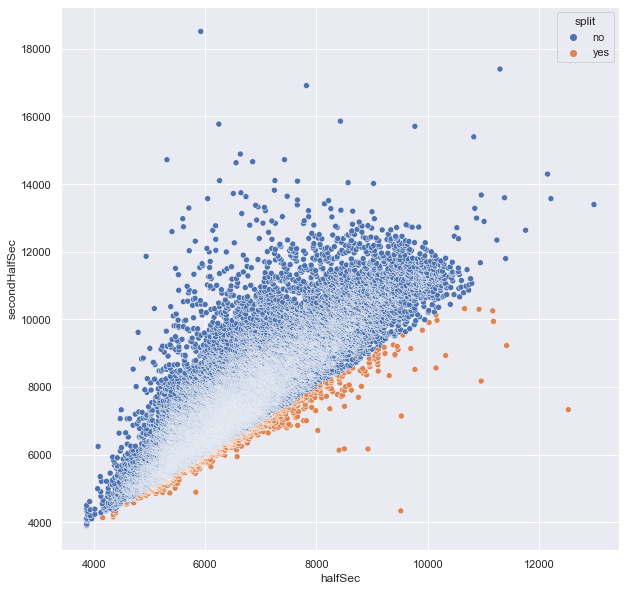

In [36]:
sns.scatterplot(data=dat3, x="halfSec", y="secondHalfSec", hue='split')

Those who have a split typically have a first-half-time that is close to the second-half-time.  
(they are good at controlling their energy?).

Many that are slower in the second half, are much slower.

Lets define a splitScore = 100*(halfSec/secondHalfSec) as a measure for the extend to which the runner ran a splitted race.  
score < 1 first half faster than second half   
score > 1 second half faster than first half

In [37]:
dat4 = sqldf("""
SELECT runID, sex, age, country, citizen, halfTime, endTime, halfSec, secondHalfSec, endSec, split,
    CAST( 100*halfSec/secondHalfSec AS integer) AS splitScore
FROM dat3
ORDER BY runID
""")
print(dat4.shape)
dat4.head()

(26393, 12)


,runID,sex,age,country,citizen,halfTime,endTime,halfSec,secondHalfSec,endSec,split,splitScore
0,0,M,24,KEN,NaN,1:04:35,2:09:37,3875,3902,7777,no,99
1,1,M,30,USA,NaN,1:04:35,2:09:58,3875,3923,7798,no,98
2,2,M,25,JPN,NaN,1:04:36,2:10:28,3876,3952,7828,no,98
3,3,M,32,USA,NaN,1:04:45,2:12:08,3885,4043,7928,no,96
4,4,M,31,KEN,NaN,1:04:35,2:12:35,3875,4080,7955,no,94


<AxesSubplot:xlabel='splitScore', ylabel='Count'>

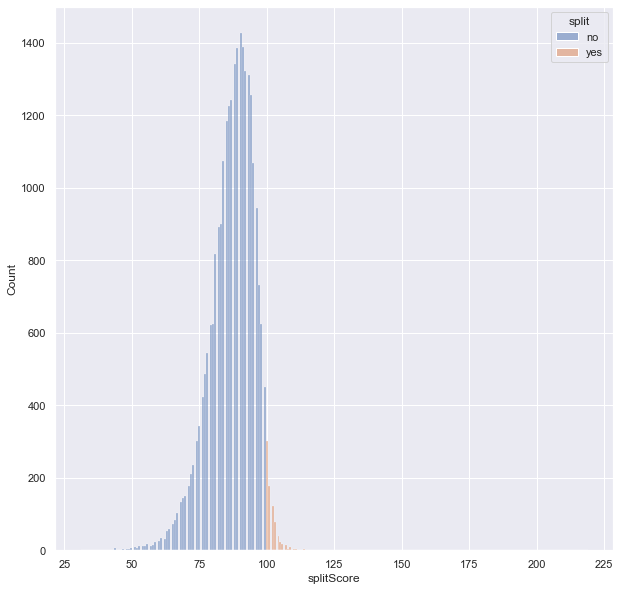

In [38]:
sns.histplot(data=dat4, x="splitScore", hue="split")

In [39]:
# only display scores between 50 and 125
dat4a = sqldf("SELECT * FROM dat4 WHERE splitScore > 50 AND splitscore < 110")

<AxesSubplot:xlabel='splitScore', ylabel='Count'>

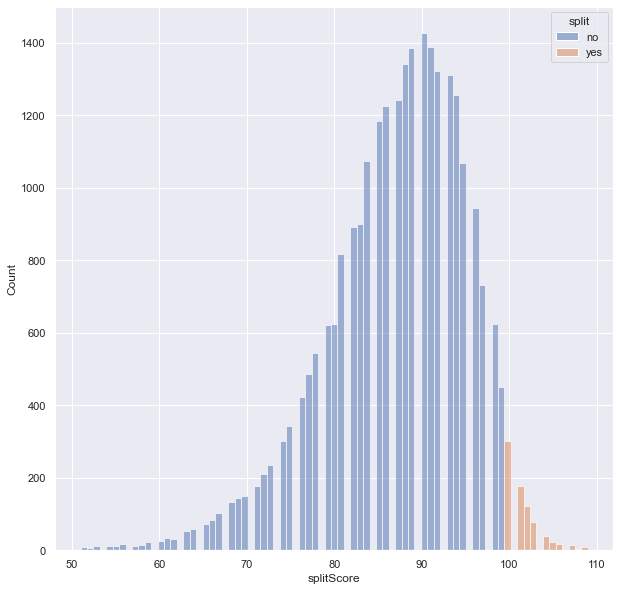

In [40]:
sns.histplot(data=dat4a, x="splitScore", hue="split")

In [41]:
sqldf("SELECT AVG(splitScore) AS mean, stddev_pop(splitScore) AS sd FROM dat4")

,mean,sd
0,87.091388,8.354463


This looks very much like a normal distribution with mean 87 AND std_dev 8.35

# Playtime

Lets investigate the extreme low and high splitsScores

In [42]:
extrem_splits = sqldf(""" 
SELECT runID, halfSec, secondHalfSec, split, splitScore
FROM dat4 
WHERE splitScore > 150 OR splitScore < 40
ORDER BY splitScore
""")
print(extrem_splits.shape)
extrem_splits.head(30)

(5, 5)


,runID,halfSec,secondHalfSec,split,splitScore
0,26400,5923,18511,no,31
1,25617,5316,14718,no,36
2,26368,6248,15771,no,39
3,25510,12524,7329,yes,170
4,12986,9516,4337,yes,219


The runner info can be found in dat_tot, lets have a look at the extreme split runners

In [43]:
sqldf("""
SELECT * 
FROM dat_tot
WHERE runID IN (SELECT runID FROM extrem_splits)
ORDER BY runID
""")

,runID,Bib,Name,age,sex,City,State,country,citizen,Unnamed: 9,...,25K,30K,35K,40K,Pace,Proj Time,endTime,Overall,Gender,Division
0,12986,28020,"Dabene, Paul Jr.",24,M,Boston,MA,USA,NaN,NaN,...,3:11:31,-,3:13:02,3:39:21,0:08:49,-,3:50:53,12988,8570,3459
1,25510,21281,"Buchsbaum, Sean M.",28,M,Somerville,MA,USA,NaN,NaN,...,3:50:05,4:17:47,4:46:34,5:18:34,0:12:38,-,5:30:53,25512,14063,4668
2,25617,1653,"Rinauro, Justin D.",21,M,Bellingham,WA,USA,NaN,NaN,...,1:45:10,2:06:36,2:29:00,5:21:59,0:12:45,-,5:33:54,25619,14099,4679
3,26368,3898,"Finck, Bryce H.",30,M,Durham,NC,USA,AUS,NaN,...,2:12:40,4:51:28,5:22:47,5:50:32,0:14:00,-,6:06:59,26370,14413,4765
4,26400,2605,"Mederos, Jonathan",32,M,South Miami,FL,USA,NaN,NaN,...,2:03:34,2:47:11,5:45:51,6:27:22,0:15:32,-,6:47:14,26402,14431,4770


So the profile of our extremist is: a  young adult male from the USA.   

NB, our N=5, so we should not generalize these findings to the whole of the USA population.

Note that Paul Dabene Jr (12986) has a 25K time of 3:11:31 and a 35K time 3:13:02. Taken these data as gospel truth we may conclude that Paul preformed a miracle, he ran 10 km in 91 seconds. Those who do not believe in miracles probably will conclude that something went wrong with the time recording (Paul might very well be a solid citizen, not an extremist).

Lets see if Google can provide us with pictures of the worst extremist:
- runID = 26400 with score  31 aka Jonathan Mederos from South Miami
- runID = 12986 with score 219 aka Paul Dabene Jr from Boston

Here is what Google found:

![boston_extrem_runners](./art/extremist.JPG)


Lets personalize our scatterplot.

I will do this with ggplot (it can be done in matplotlib, but that is a lot of work)  
Warning: ggplot takes about a minute to render this plot.

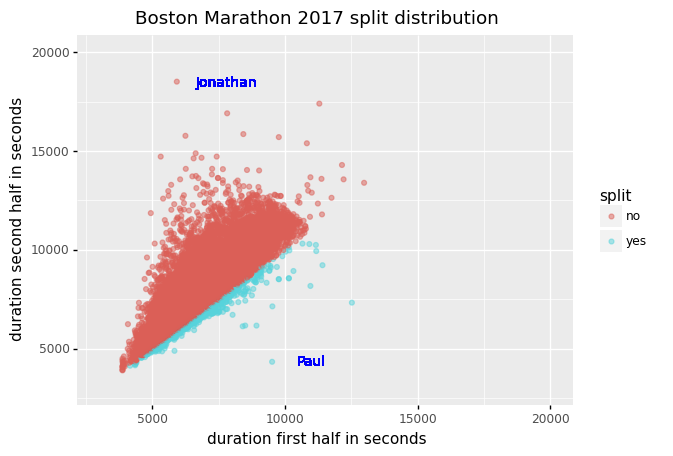

<ggplot: (-9223371878011588444)>

In [44]:
ggplot(data=dat3, mapping=aes(x="halfSec", y="secondHalfSec", color='split')) + \
    geom_point(alpha=0.5) + \
    geom_text(x=7800,  y=18500, label='Jonathan', size=10, color='blue') + \
    geom_text(x=11000, y=4400,  label='Paul'    , size=10, color='blue') + \
    xlim([3000,20000]) + ylim([3000,20000]) + \
    ggtitle('Boston Marathon 2017 split distribution') + \
    xlab('duration first half in seconds') + ylab('duration second half in seconds')

## Fantasy marathon running

Suppose I can not suppress the urge to pretend that I also ran the marathon. In this fantasy world I'm a 30 year old NLD male who has a halfSec=7500 and secondHalfSec=10000 so my split='no'.

- I want to see where I'm positioned in the cloud of dots.
- furthermore, I do not like crowds. So lets remove most of my competitors from the race, let's randomly remove 97% of the red dots, that leaves us with about as many red as there are blue dots.
- I also want to get rid of the awkward text labels for Paul and Jonathan, they should each get an uniquely colored dot. I want their dots the be big so we can spot them quickly. For myself, there should also be an unique color and an even bigger dot.

Lets make a plot that does all of this.

In [45]:
# build an apropiate dataframe with the base data

# select the columns that we really need
fan = sqldf("SELECT runID, halfSec, secondHalfSec, split FROM dat3 ORDER BY 1")
print(fan.shape)
fan.tail()

(26393, 4)


,runID,halfSec,secondHalfSec,split
26388,26405,12211,13568,no
26389,26406,10826,15393,no
26390,26407,12984,13393,no
26391,26408,12150,14294,no
26392,26409,11296,17398,no


In [46]:
# create two dataframes, one for runners with positive split. and one for those who have a negatieve split
negsplit = sqldf("SELECT * FROM fan WHERE split='no'  ")
print(negsplit.shape)
possplit = sqldf("SELECT * FROM fan WHERE split='yes' ")
print(possplit.shape)

(25582, 4)
(811, 4)


In [47]:
# keep the data of Jonathan -runnID = 26400 - in a dataframe Jonathan, 
# after that remove him from from the negsplit dataframe

In [48]:
jonathan = sqldf("SELECT * FROM negsplit WHERE runID = 26400")
print(jonathan.head())

   runID  halfSec  secondHalfSec split
0  26400     5923          18511    no


In [49]:
# remove jonathan from negsplit
negsplit = sqldf("SELECT * FROM negsplit WHERE runID <> 26400  ")
print(negsplit.shape)

(25581, 4)


In [50]:
# take a sample from negsplit, take sample size 809, 
# jonathan and me will be added to the sample later, 
# so there will be 811 cases with a negative and 811 with a positive split
negSplitSample = negsplit.sample(n=809)
print(negSplitSample.shape)

(809, 4)


In [51]:
# create a dataframe with my data
me = pd.DataFrame(data={'runID':26410, 'halfSec':7500, "secondHalfSec":10000, "split":'no'}, index=[0] )
me.head()

,runID,halfSec,secondHalfSec,split
0,26410,7500,10000,no


In [52]:
# then collect all the pieces together in one final fantasy dataframe
finfan0 = sqldf("""
SELECT * FROM possplit
UNION
SELECT * FROM negSplitSample
UNION
SELECT * FROM jonathan
UNION
SELECT * FROM me
ORDER BY runID
""")
print(finfan0.shape)
finfan0.head()

(1622, 4)


,runID,halfSec,secondHalfSec,split
0,15,4163,4137,yes
1,20,4353,4159,yes
2,23,4353,4218,yes
3,24,4353,4227,yes
4,30,4398,4282,yes


In [53]:
# now construct a final fantasy where Paul, Jonathan and me get our own color and size
# Paul= 26400, Jonathan = 12986 and me is 26410
finfan = sqldf("""
SELECT runID, halfSec, secondHalfSec, split,
    CASE
        WHEN runID == 26400 THEN 250
        WHEN runID == 12986 THEN 250
        WHEN runID == 26410 THEN 1000
        ELSE 1
    END AS size,
    CASE
        WHEN runID == 26400 THEN 'Paul'
        WHEN runID == 12986 THEN 'Jonathan'
        WHEN runID == 26410 THEN 'Me'
        WHEN split == 'yes' AND runID NOT IN (26400,12986,26410) THEN 'negative split'
        WHEN split == 'no'  AND runID NOT IN (26400,12986,26410) THEN 'positive split'
        ELSE '?'
    END AS label
FROM finfan0        
ORDER BY runID
""")
print(finfan.shape)
finfan.head()

(1622, 6)


,runID,halfSec,secondHalfSec,split,size,label
0,15,4163,4137,yes,1,negative split
1,20,4353,4159,yes,1,negative split
2,23,4353,4218,yes,1,negative split
3,24,4353,4227,yes,1,negative split
4,30,4398,4282,yes,1,negative split


In [54]:
sqldf("SELECT label, COUNT(*) AS cnt FROM finfan GROUP BY label")

,label,cnt
0,negative split,810
1,positive split,809
2,Jonathan,1
3,Paul,1
4,Me,1


In [55]:
sqldf("SELECT split, COUNT(*) AS cnt FROM finfan GROUP BY split")

,split,cnt
0,yes,811
1,no,811


Now, use the data frame finfan to produce the required plot

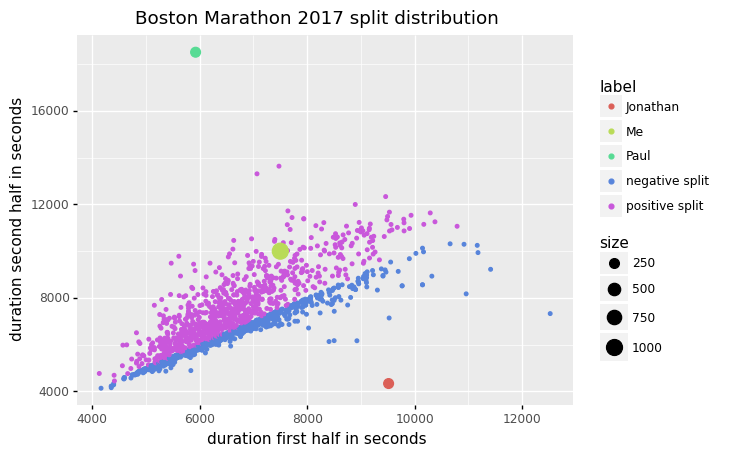

<ggplot: (-9223371877964152956)>

In [56]:
ggplot(data=finfan, mapping=aes(x="halfSec", y="secondHalfSec", color='label', size='size')) + \
    geom_point(alpha=1) + \
    ggtitle('Boston Marathon 2017 split distribution') + \
    xlab('duration first half in seconds') + ylab('duration second half in seconds')

There are 811 positive and 811 negative splits (the positive ones were randomly samples, hence representative for their group).  
So from the plot we may conclude that the positive splits are more spread out than the negative splits.

<AxesSubplot:xlabel='halfSec', ylabel='secondHalfSec'>

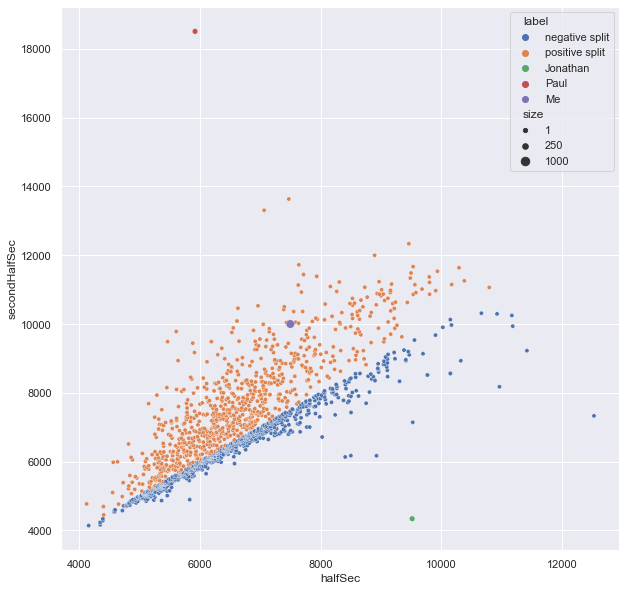

In [57]:
# seaborn can almost do the same
sns.scatterplot(data=finfan, x="halfSec", y="secondHalfSec", hue='label',size='size')

The size parameter in Seaborn is interpreted as a categorical, not as an integer representing the required size.  
But for the rest the plots are basically the same.